### Table of contents <a id="toc"></a>

- [working dataset](#working_dataset)
- [first import](#first_import)
- [second import](#second_import)
- [third import](#third_import)
- ...
- [basic dataframe for models training](#dataframe_model)
- [model train & save](#model)
- [predictions](#predictions)



In [1]:

import pandas as pd
import numpy as np

from joblib import dump, load

from sklearn.metrics import *

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor, make_column_transformer

from sklearn.linear_model import SGDRegressor, LinearRegression


## Working Dataset <a id="working_dataset"></a>

In [2]:
# dataframe for our model

my_dataset =  pd.DataFrame({
                'cnit': pd.Series(dtype='object'),
                'mine': pd.Series(dtype='object'),
                'marque': pd.Series(dtype='object'),
                'modele': pd.Series(dtype='object'),
                'dscom': pd.Series(dtype='object'),
                'carburant': pd.Series(dtype='object'),
                'hybride': pd.Series(dtype='bool'), # hybride (True or False) bool or boolean
                'puiss_admin': pd.Series(dtype='float'),
                'puiss_max': pd.Series(dtype='float'),
                'boite_v_auto': pd.Series(dtype='bool'), # boite de vitesse : automatique (True) ou manuelle (False)
                'boite_v_rapp': pd.Series(dtype='int'), # boite de vitesse : nb de rapports
                'conso_urb': pd.Series(dtype='float'),
                'conso_exurb': pd.Series(dtype='float'),
                'conso_mixte': pd.Series(dtype='float'),
                'co2': pd.Series(dtype='float'),
                'dataset': pd.Series(dtype='int')
                })

[Back to top](#toc)

## First import <a id="first_import"></a>

In [3]:
# original dataset

df_2011 = pd.read_excel("datasets/2011_BASE CL MAJ JUIN 2011.xls")
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37816 entries, 0 to 37815
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lib_mrq            37816 non-null  object 
 1   lib_mod_doss       37816 non-null  object 
 2   lib_mod            37816 non-null  object 
 3   dscom              37816 non-null  object 
 4   cnit               37816 non-null  object 
 5   tvv                37816 non-null  object 
 6   typ_cbr            37816 non-null  object 
 7   puiss_admin_98     37816 non-null  int64  
 8   puiss_max          37816 non-null  float64
 9   typ_boite_nb_rapp  37816 non-null  object 
 10  conso_urb          37774 non-null  float64
 11  conso_exurb        37774 non-null  float64
 12  conso_mixte        37775 non-null  float64
 13  co2                37775 non-null  float64
 14  champ_v9           37794 non-null  object 
 15  date_maj           37816 non-null  object 
dtypes: float64(5), int64(1

In [4]:
# gearbox - boite de vitesse

df_2011['boite_v_rapp'] = df_2011['typ_boite_nb_rapp'].str.extract(r'(?P<digit>\d)')
# df_2011['boite_v_rapp'] = df_2011['typ_boite_nb_rapp'].str.extract('(\d+)')

df_2011['boite_v_auto'] = df_2011['typ_boite_nb_rapp'].str.extract(r'(?P<letter>[AM])').replace({'A': True, 'M': False})

df_2011[['typ_boite_nb_rapp', 'boite_v_auto', 'boite_v_rapp']]

,typ_boite_nb_rapp,boite_v_auto,boite_v_rapp
0,M 5,False,5
1,M 5,False,5
2,M 5,False,5
3,M 5,False,5
4,M 5,False,5
...,...,...,...
37811,A 6,True,6
37812,A 6,True,6
37813,A 6,True,6
37814,A 6,True,6


In [5]:
# columns correspondance
df_2011_cols = {"cnit" : "cnit",
                "tvv" : "mine",
                "lib_mrq" : "marque",
                "lib_mod" : "modele",
                "dscom" : "dscom",
                "typ_cbr" : "carburant",
                "puiss_admin_98" : "puiss_admin",
                "puiss_max" : "puiss_max",
                "conso_urb" : "conso_urb",
                "conso_exurb" : "conso_exurb",
                "conso_mixte" : "conso_mixte",
                "co2" : "co2"
               }

df_2011 = df_2011.rename(columns=df_2011_cols)

In [6]:
# columns cleaning - columns to drop
col_to_drop = []
for c in df_2011.columns :
    if c not in my_dataset.columns:
        col_to_drop.append(c)

df_2011 = df_2011.drop(columns=col_to_drop)
print(col_to_drop, "dropped!")

['lib_mod_doss', 'typ_boite_nb_rapp', 'champ_v9', 'date_maj'] dropped!


In [7]:
# missing columns - columns to add
missing_columns = []
for c in my_dataset.columns :
    if c not in df_2011.columns:
        missing_columns.append(c)

print(missing_columns, "missing!")

['hybride', 'dataset'] missing!


In [8]:
# add missing columns, drop empty entries
df_2011['hybride'] = False
df_2011['dataset'] = 2011

In [9]:
# clean - drop empty entries
df_2011 = df_2011.dropna()

In [10]:
# drop duplicate cnit (unique identifier)
df_2011.drop_duplicates(subset=['cnit'], inplace=True)

In [11]:
df_2011.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37429 entries, 0 to 37815
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        37429 non-null  object 
 1   modele        37429 non-null  object 
 2   dscom         37429 non-null  object 
 3   cnit          37429 non-null  object 
 4   mine          37429 non-null  object 
 5   carburant     37429 non-null  object 
 6   puiss_admin   37429 non-null  int64  
 7   puiss_max     37429 non-null  float64
 8   conso_urb     37429 non-null  float64
 9   conso_exurb   37429 non-null  float64
 10  conso_mixte   37429 non-null  float64
 11  co2           37429 non-null  float64
 12  boite_v_rapp  37429 non-null  object 
 13  boite_v_auto  37429 non-null  object 
 14  hybride       37429 non-null  bool   
 15  dataset       37429 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(8)
memory usage: 4.6+ MB


In [12]:
# data types concordance
df_2011 = df_2011.astype(my_dataset.dtypes.to_dict())
df_2011.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37429 entries, 0 to 37815
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        37429 non-null  object 
 1   modele        37429 non-null  object 
 2   dscom         37429 non-null  object 
 3   cnit          37429 non-null  object 
 4   mine          37429 non-null  object 
 5   carburant     37429 non-null  object 
 6   puiss_admin   37429 non-null  float64
 7   puiss_max     37429 non-null  float64
 8   conso_urb     37429 non-null  float64
 9   conso_exurb   37429 non-null  float64
 10  conso_mixte   37429 non-null  float64
 11  co2           37429 non-null  float64
 12  boite_v_rapp  37429 non-null  int64  
 13  boite_v_auto  37429 non-null  bool   
 14  hybride       37429 non-null  bool   
 15  dataset       37429 non-null  int64  
dtypes: bool(2), float64(6), int64(2), object(6)
memory usage: 4.4+ MB


In [13]:
#  import
my_dataset = pd.concat([my_dataset, df_2011])
my_dataset.reset_index(inplace=True, drop=True)
my_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37429 entries, 0 to 37428
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnit          37429 non-null  object 
 1   mine          37429 non-null  object 
 2   marque        37429 non-null  object 
 3   modele        37429 non-null  object 
 4   dscom         37429 non-null  object 
 5   carburant     37429 non-null  object 
 6   hybride       37429 non-null  bool   
 7   puiss_admin   37429 non-null  float64
 8   puiss_max     37429 non-null  float64
 9   boite_v_auto  37429 non-null  bool   
 10  boite_v_rapp  37429 non-null  int64  
 11  conso_urb     37429 non-null  float64
 12  conso_exurb   37429 non-null  float64
 13  conso_mixte   37429 non-null  float64
 14  co2           37429 non-null  float64
 15  dataset       37429 non-null  int64  
dtypes: bool(2), float64(6), int64(2), object(6)
memory usage: 4.1+ MB


[Back to top](#toc)

## Second import (update) <a id="second_import"></a>

In [14]:
# dataset
df_2012 = pd.read_csv("datasets/2012_BASE CL MAJ JUIN 2012.csv", sep=';',encoding = 'latin-1')
df_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40052 entries, 0 to 40051
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lib_mrq            40052 non-null  object 
 1   lib_mod_doss       40052 non-null  object 
 2   lib_mod            40052 non-null  object 
 3   dscom              40052 non-null  object 
 4   cnit               40052 non-null  object 
 5   tvv                40052 non-null  object 
 6   typ_cbr            40052 non-null  object 
 7   hybride            40052 non-null  object 
 8   puiss_admin_98     40052 non-null  int64  
 9   puiss_max          40052 non-null  int64  
 10  typ_boite_nb_rapp  40052 non-null  object 
 11  conso_urb          40020 non-null  object 
 12  conso_exurb        40020 non-null  object 
 13  conso_mixte        40022 non-null  object 
 14  co2                40022 non-null  float64
 15  co_typ_1           39905 non-null  object 
 16  hc                 835

In [15]:
# gearbox - boite de vitesse

# df_2012['boite_v_rapp'] = df_2012['typ_boite_nb_rapp'].str.extract(r'(?P<digit>\d)')
df_2012['boite_v_rapp'] = df_2012['typ_boite_nb_rapp'].str.extract('(\d+)')

df_2012['boite_v_auto'] = df_2012['typ_boite_nb_rapp'].str.extract(r'(?P<letter>[AM])').replace({'A': True, 'M': False})

df_2012[['typ_boite_nb_rapp', 'boite_v_auto', 'boite_v_rapp']]

,typ_boite_nb_rapp,boite_v_auto,boite_v_rapp
0,M 6,False,6
1,M 6,False,6
2,M 6,False,6
3,M 6,False,6
4,M 6,False,6
...,...,...,...
40047,M 6,False,6
40048,M 6,False,6
40049,M 6,False,6
40050,M 6,False,6


In [16]:
# hybrid
df_2012['hybride'] = df_2012['hybride'].replace({'oui': True, 'non': False})
df_2012['hybride'].value_counts()


False    39911
True       141
Name: hybride, dtype: int64

In [17]:
# conso
df_2012['conso_urb'] = df_2012['conso_urb'].str.replace(',','.')
df_2012['conso_exurb'] = df_2012['conso_exurb'].str.replace(',','.')
df_2012['conso_mixte'] = df_2012['conso_mixte'].str.replace(',','.')


In [18]:
# columns correspondance
df_2012_cols = {"cnit" : "cnit",
                "tvv" : "mine",
                "lib_mrq" : "marque",
                "lib_mod" : "modele",
                "dscom" : "dscom",
                "typ_cbr" : "carburant",
                "hybride" : "hybride",
                "puiss_admin_98" : "puiss_admin",
                "puiss_max" : "puiss_max",
                "conso_urb" : "conso_urb",
                "conso_exurb" : "conso_exurb",
                "conso_mixte" : "conso_mixte",
                "co2" : "co2"
               }

df_2012 = df_2012.rename(columns=df_2012_cols)


In [19]:
# columns cleaning - columns to drop
col_to_drop = []
for c in df_2012.columns :
    if c not in my_dataset.columns:
        col_to_drop.append(c)

df_2012 = df_2012.drop(columns=col_to_drop)
print(col_to_drop, "dropped!")

['lib_mod_doss', 'typ_boite_nb_rapp', 'co_typ_1', 'hc', 'nox', 'hcnox', 'ptcl', 'masse_ordma_min', 'masse_ordma_max', 'champ_v9', 'date_maj', 'Carrosserie', 'gamme'] dropped!


In [20]:
# missing columns - columns to add
missing_columns = []
for c in my_dataset.columns :
    if c not in df_2012.columns:
        missing_columns.append(c)

print(missing_columns, "missing!")

['dataset'] missing!


In [21]:
# add missing columns
df_2012['dataset'] = 2012

In [22]:
# clean - drop empty entries
df_2012 = df_2012.dropna()

In [23]:
# drop duplicate cnit (unique identifier)
df_2012.drop_duplicates(subset=['cnit'], inplace=True)
df_2012.reset_index(inplace=True, drop=True)

In [24]:
df_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39352 entries, 0 to 39351
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        39352 non-null  object 
 1   modele        39352 non-null  object 
 2   dscom         39352 non-null  object 
 3   cnit          39352 non-null  object 
 4   mine          39352 non-null  object 
 5   carburant     39352 non-null  object 
 6   hybride       39352 non-null  bool   
 7   puiss_admin   39352 non-null  int64  
 8   puiss_max     39352 non-null  int64  
 9   conso_urb     39352 non-null  object 
 10  conso_exurb   39352 non-null  object 
 11  conso_mixte   39352 non-null  object 
 12  co2           39352 non-null  float64
 13  boite_v_rapp  39352 non-null  object 
 14  boite_v_auto  39352 non-null  object 
 15  dataset       39352 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(11)
memory usage: 4.5+ MB


In [25]:
# data types concordance
df_2012 = df_2012.astype(my_dataset.dtypes.to_dict())
df_2012.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39352 entries, 0 to 39351
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        39352 non-null  object 
 1   modele        39352 non-null  object 
 2   dscom         39352 non-null  object 
 3   cnit          39352 non-null  object 
 4   mine          39352 non-null  object 
 5   carburant     39352 non-null  object 
 6   hybride       39352 non-null  bool   
 7   puiss_admin   39352 non-null  float64
 8   puiss_max     39352 non-null  float64
 9   conso_urb     39352 non-null  float64
 10  conso_exurb   39352 non-null  float64
 11  conso_mixte   39352 non-null  float64
 12  co2           39352 non-null  float64
 13  boite_v_rapp  39352 non-null  int64  
 14  boite_v_auto  39352 non-null  bool   
 15  dataset       39352 non-null  int64  
dtypes: bool(2), float64(6), int64(2), object(6)
memory usage: 4.3+ MB


In [26]:
#  import last dataset : if cnit already exists -> keep last
to_drop = my_dataset[my_dataset['cnit'].isin(df_2012['cnit'])]

print("working dataset has",my_dataset.shape[0], "entries")
print("import dataset has",df_2012.shape[0], "entries")
print(to_drop.shape[0], "duplicate entries will be removed from working dataset")

# drop duplicates & import
my_dataset = my_dataset.drop(index=to_drop.index)
my_dataset = pd.concat([my_dataset, df_2012])
my_dataset.reset_index(inplace=True, drop=True)

print("working dataset has now",my_dataset.shape[0], "entries")


working dataset has 37429 entries
import dataset has 39352 entries
7126 duplicate entries will be removed from working dataset
working dataset has now 69655 entries


In [27]:
my_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69655 entries, 0 to 69654
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnit          69655 non-null  object 
 1   mine          69655 non-null  object 
 2   marque        69655 non-null  object 
 3   modele        69655 non-null  object 
 4   dscom         69655 non-null  object 
 5   carburant     69655 non-null  object 
 6   hybride       69655 non-null  bool   
 7   puiss_admin   69655 non-null  float64
 8   puiss_max     69655 non-null  float64
 9   boite_v_auto  69655 non-null  bool   
 10  boite_v_rapp  69655 non-null  int64  
 11  conso_urb     69655 non-null  float64
 12  conso_exurb   69655 non-null  float64
 13  conso_mixte   69655 non-null  float64
 14  co2           69655 non-null  float64
 15  dataset       69655 non-null  int64  
dtypes: bool(2), float64(6), int64(2), object(6)
memory usage: 7.6+ MB


## Third import (update) <a id="third_import"></a>

In [28]:
# dataset
df_2013 = pd.read_csv("datasets/2013_cl_JUIN_2013-complet3.csv", sep=';',encoding = 'latin-1')
df_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44850 entries, 0 to 44849
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Marque                                44850 non-null  object 
 1   Modèle dossier                        44850 non-null  object 
 2   Modèle UTAC                           44850 non-null  object 
 3   Désignation commerciale               44850 non-null  object 
 4   CNIT                                  44850 non-null  object 
 5   Type Variante Version (TVV)           44850 non-null  object 
 6   Carburant                             44850 non-null  object 
 7   Hybride                               44850 non-null  object 
 8   Puissance administrative              44850 non-null  int64  
 9   Puissance maximale (kW)               44850 non-null  float64
 10  Boîte de vitesse                      44850 non-null  object 
 11  Consommation ur

In [29]:
# gearbox - boite de vitesse

df_2013['boite_v_rapp'] = df_2013['Boîte de vitesse'].str.extract(r'(?P<digit>\d)')

df_2013['boite_v_auto'] = df_2013['Boîte de vitesse'].str.extract(r'(?P<letter>[AM])').replace({'A': True, 'M': False})

df_2013[['Boîte de vitesse', 'boite_v_auto', 'boite_v_rapp']]


,Boîte de vitesse,boite_v_auto,boite_v_rapp
0,M 6,False,6
1,M 6,False,6
2,M 6,False,6
3,M 6,False,6
4,M 6,False,6
...,...,...,...
44845,A 6,True,6
44846,M 6,False,6
44847,A 6,True,6
44848,M 6,False,6


In [30]:
# hybrid
df_2013['Hybride'] = df_2013['Hybride'].replace({'oui': True, 'non': False})
df_2013['Hybride'].value_counts()

False    44593
True       257
Name: Hybride, dtype: int64

In [31]:
# columns correspondance
df_2013_cols = {"CNIT" : "cnit",
                "Type Variante Version (TVV)" : "mine",
                "Marque" : "marque",
                "Modèle dossier" : "modele",
                "Désignation commerciale" : "dscom",
                "Carburant" : "carburant",
                "Hybride" : "hybride",
                "Puissance administrative" : "puiss_admin",
                "Puissance maximale (kW)" : "puiss_max",
                "Consommation urbaine (l/100km)" : "conso_urb",
                "Consommation extra-urbaine (l/100km)" : "conso_exurb",
                "Consommation mixte (l/100km)" : "conso_mixte",
                "CO2 (g/km)" : "co2"
               }

df_2013 = df_2013.rename(columns=df_2013_cols)


In [32]:
# columns cleaning - columns to drop
col_to_drop = []
for c in df_2013.columns :
    if c not in my_dataset.columns:
        col_to_drop.append(c)

df_2013 = df_2013.drop(columns=col_to_drop)
print(col_to_drop, "dropped!")

['Modèle UTAC', 'Boîte de vitesse', 'CO type I (g/km)', 'HC (g/km)', 'NOX (g/km)', 'HC+NOX (g/km)', 'Particules (g/km)', 'masse vide euro min (kg)', 'masse vide euro max (kg)', 'Champ V9', 'Date de mise à jour', 'Carrosserie', 'gamme'] dropped!


In [33]:
# missing columns - columns to add
missing_columns = []
for c in my_dataset.columns :
    if c not in df_2013.columns:
        missing_columns.append(c)

print(missing_columns, "missing!")

['dataset'] missing!


In [34]:
# add missing columns, drop empty entries
df_2013['dataset'] = 2013

In [35]:
# clean - drop empty entries
df_2013 = df_2013.dropna()

In [36]:
# drop duplicate cnit (unique identifier)
df_2013.drop_duplicates(subset=['cnit'], inplace=True)
df_2013.reset_index(inplace=True, drop=True)

In [37]:
df_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43926 entries, 0 to 43925
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        43926 non-null  object 
 1   modele        43926 non-null  object 
 2   dscom         43926 non-null  object 
 3   cnit          43926 non-null  object 
 4   mine          43926 non-null  object 
 5   carburant     43926 non-null  object 
 6   hybride       43926 non-null  bool   
 7   puiss_admin   43926 non-null  int64  
 8   puiss_max     43926 non-null  float64
 9   conso_urb     43926 non-null  float64
 10  conso_exurb   43926 non-null  float64
 11  conso_mixte   43926 non-null  float64
 12  co2           43926 non-null  float64
 13  boite_v_rapp  43926 non-null  object 
 14  boite_v_auto  43926 non-null  object 
 15  dataset       43926 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(8)
memory usage: 5.1+ MB


In [38]:
# data types concordance
df_2013 = df_2013.astype(my_dataset.dtypes.to_dict())
df_2013.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43926 entries, 0 to 43925
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        43926 non-null  object 
 1   modele        43926 non-null  object 
 2   dscom         43926 non-null  object 
 3   cnit          43926 non-null  object 
 4   mine          43926 non-null  object 
 5   carburant     43926 non-null  object 
 6   hybride       43926 non-null  bool   
 7   puiss_admin   43926 non-null  float64
 8   puiss_max     43926 non-null  float64
 9   conso_urb     43926 non-null  float64
 10  conso_exurb   43926 non-null  float64
 11  conso_mixte   43926 non-null  float64
 12  co2           43926 non-null  float64
 13  boite_v_rapp  43926 non-null  int64  
 14  boite_v_auto  43926 non-null  bool   
 15  dataset       43926 non-null  int64  
dtypes: bool(2), float64(6), int64(2), object(6)
memory usage: 4.8+ MB


In [39]:
#  import last dataset : if cnit already exists -> keep last
to_drop = my_dataset[my_dataset['cnit'].isin(df_2013['cnit'])]

print("working dataset has",my_dataset.shape[0], "entries")
print("import dataset has",df_2013.shape[0], "entries")
print(to_drop.shape[0], "duplicate entries will be removed from working dataset")

# # drop duplicates & import
my_dataset = my_dataset.drop(index=to_drop.index)
my_dataset = pd.concat([my_dataset, df_2013])
my_dataset.reset_index(inplace=True, drop=True)

print("working dataset has now",my_dataset.shape[0], "entries")


working dataset has 69655 entries
import dataset has 43926 entries
36294 duplicate entries will be removed from working dataset
working dataset has now 77287 entries


In [40]:
my_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnit          77287 non-null  object 
 1   mine          77287 non-null  object 
 2   marque        77287 non-null  object 
 3   modele        77287 non-null  object 
 4   dscom         77287 non-null  object 
 5   carburant     77287 non-null  object 
 6   hybride       77287 non-null  bool   
 7   puiss_admin   77287 non-null  float64
 8   puiss_max     77287 non-null  float64
 9   boite_v_auto  77287 non-null  bool   
 10  boite_v_rapp  77287 non-null  int64  
 11  conso_urb     77287 non-null  float64
 12  conso_exurb   77287 non-null  float64
 13  conso_mixte   77287 non-null  float64
 14  co2           77287 non-null  float64
 15  dataset       77287 non-null  int64  
dtypes: bool(2), float64(6), int64(2), object(6)
memory usage: 8.4+ MB


## Save dataset

In [41]:
my_dataset.to_csv('final_dataset.csv', index=False)
print("dataset saved : final_dataset.csv")

dataset saved : final_dataset.csv


[Back to top](#toc)

## Dataframe for model (basic) <a id="dataframe_model"></a>

In [42]:
my_dataset = pd.read_csv("final_dataset.csv")

In [43]:
df_model = my_dataset[['carburant', 'hybride', 
                       'puiss_admin', 'puiss_max',
                       'boite_v_auto', 'boite_v_rapp', 
                       'conso_urb', 'conso_exurb', 'conso_mixte',
                       'co2']]

In [44]:
df_model

,carburant,hybride,puiss_admin,puiss_max,boite_v_auto,boite_v_rapp,conso_urb,conso_exurb,conso_mixte,co2
0,ES,False,7.0,77.0,False,5,11.3,6.4,8.2,196.0
1,ES,False,8.0,88.0,False,5,11.2,6.4,8.2,194.0
2,ES,False,7.0,77.0,False,5,11.3,6.4,8.2,196.0
3,ES,False,8.0,88.0,False,5,11.2,6.4,8.2,194.0
4,ES,False,10.0,110.0,False,5,12.1,7.0,8.9,211.0
...,...,...,...,...,...,...,...,...,...,...
77282,GO,False,10.0,120.0,True,6,8.6,5.2,6.4,169.0
77283,GO,False,9.0,120.0,False,6,6.1,4.8,5.3,139.0
77284,GO,False,9.0,120.0,True,6,7.7,4.8,5.9,154.0
77285,GO,False,9.0,120.0,False,6,6.8,4.5,5.3,139.0


In [45]:
df_model.loc[:, 'carburant'] = df_model['carburant'].str.replace('/','-')
df_model['carburant'].value_counts()


/tmp/ipykernel_827/1684076048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, 'carburant'] = df_model['carburant'].str.replace('/','-')


GO       60930
ES       15886
FE         110
EH         107
ES-GN       98
GN          61
GH          54
ES-GP       39
GN-ES        1
GL           1
Name: carburant, dtype: int64

[Back to top](#toc)

## Best features <a id="features_select"></a>

In [46]:
X = df_model.drop(columns=['co2', 'carburant'])
y = df_model['co2']

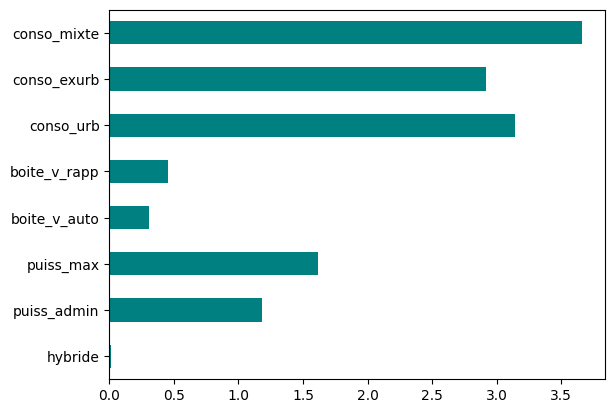

In [47]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

importances = mutual_info_regression(X,y)

feat_importance = pd.Series(importances, X.columns)
feat_importance.plot(kind='barh', color='teal')
plt.show()

## Model <a id="model"></a>

Model SGDRegressor with standardized features & pipeline.

In [48]:
X = df_model.drop(columns=['co2'])
X = X.drop(columns=['conso_exurb', 'conso_urb']) # 'puiss_max', 'conso_urb', 'conso_mixte'

y = df_model['co2']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =5)


In [50]:
feat_num = X.select_dtypes(include = ['float', 'int']).columns.to_list()
feat_cat = X.select_dtypes(include = ['object']).columns.to_list()

# not scaling gearbox
# feat_num.remove('boite_v_rapp')

print("features numerical:", feat_num)
print("features categorical:", feat_cat)


features numerical: ['puiss_admin', 'puiss_max', 'boite_v_rapp', 'conso_mixte']
features categorical: ['carburant']


In [51]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))
preprocessor = make_column_transformer( 
                          (num_pipeline, feat_num),
                          (cat_pipeline, feat_cat)
                        )

In [52]:
# 0.0001 0.0002
model = make_pipeline(preprocessor, TransformedTargetRegressor(regressor = SGDRegressor(alpha = 0.0001,
                                                                epsilon = 0, penalty ='l1', random_state =5))
    
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['puiss_admin', 'puiss_max',
                                                   'boite_v_rapp',
                                                   'conso_mixte']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['carburant'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=SGDRegressor(epsilon=0,
                                                                   penalty='l1',
                                                                   random_state=5)))])

In [53]:
y_pred = model.predict(X_test)


In [54]:
model_score = np.round(model.score(X_test, y_test), 5)
model_mae = np.round(mean_absolute_error(y_test,y_pred),2)
model_rmse = np.round(np.sqrt(mean_absolute_error(y_test,y_pred)), 3)

print(f"score R2 de performance sur le test set : {model_score}")
print(f"mean absolute error (MAE) : {model_mae}")
print(f"RMSE :{model_rmse}")

score R2 de performance sur le test set : 0.9943
mean absolute error (MAE) : 2.03
RMSE :1.426


In [55]:
X_test.iloc[0]

carburant          GO
hybride         False
puiss_admin       8.0
puiss_max       103.0
boite_v_auto     True
boite_v_rapp        6
conso_mixte       6.3
Name: 76563, dtype: object

In [56]:
my_prediction = pd.DataFrame(X_test.iloc[0].values.reshape(1,-1), columns=X_test.columns)
my_prediction.shape

(1, 7)

In [57]:
# predicted value
model.predict(my_prediction)[0]

167.73457147474633

In [58]:
# real value
y_test.iloc[0]

166.0

__Another model :__

Model LinearRegression with standardized features + PolynomialFeatures & pipeline.

In [59]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))
preprocessor = make_column_transformer( 
                          (num_pipeline, feat_num),
                          (cat_pipeline, feat_cat)
                        )

In [60]:
model_lr = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())

model_lr.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['puiss_admin', 'puiss_max',
                                                   'boite_v_rapp',
                                                   'conso_mixte']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['carburant'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [61]:
y_pred_lr = model_lr.predict(X_test)


In [62]:
lr_score = np.round(model_lr.score(X_test, y_test), 5)
lr_mae = np.round(mean_absolute_error(y_test,y_pred_lr),2)
lr_rmse = np.round(np.sqrt(mean_absolute_error(y_test,y_pred_lr)), 3)

print(f"score R2 de performance sur le test set : {lr_score}")
print(f"mean absolute error (MAE) : {lr_mae}")
print(f"RMSE :{lr_rmse}")


score R2 de performance sur le test set : -73518444652.48424
mean absolute error (MAE) : 117819.23
RMSE :343.248


In [63]:
my_prediction = pd.DataFrame(X_test.iloc[0].values.reshape(1,-1), columns=X_test.columns)
my_prediction.shape

(1, 7)

In [64]:
# predicted value
model_lr.predict(my_prediction)[0]

165.60615245997906

In [65]:
# real value
y_test.iloc[0]

166.0

[Back to top](#toc)

## Save model

In [66]:
dump(model, 'final_model.joblib')


['final_model.joblib']

## Predictions <a id="predictions"></a>

In [67]:
final_model = load('final_model.joblib')
final_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['puiss_admin', 'puiss_max',
                                                   'boite_v_rapp',
                                                   'conso_mixte']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['carburant'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=SGDRegressor(epsilon=0,
                                                                   penalty='l1',
                                                                   random_state=5)))])

In [68]:
# default values
# REQUIRED : carburant, puiss_admin
default_val = {
    'hybride': False,
    'puiss_admin': df_model['puiss_admin'].value_counts().idxmax(), # most common value
    'puiss_max': df_model['puiss_max'].mean(), # mean value
    'conso_urb' : df_model['conso_urb'].mean(), # mean value
    'conso_exurb' : df_model['conso_exurb'].mean(), # mean value
    'conso_mixte' : df_model['conso_mixte'].mean(), # mean value
    'boite_v_auto' : False,
    'boite_v_rapp': df_model['boite_v_rapp'].value_counts().idxmax(), # most common value
}

In [69]:
my_car = {
    'carburant': "GO",
    'hybride': False,
    'puiss_admin': 6.0,
    'puiss_max': 88.0,
    'conso_urb' : None,
    'conso_exurb' : None,
    'conso_mixte' : None,
    'boite_v_auto' : False,
    'boite_v_rapp': 6
}

my_car

{'carburant': 'GO',
 'hybride': False,
 'puiss_admin': 6.0,
 'puiss_max': 88.0,
 'conso_urb': None,
 'conso_exurb': None,
 'conso_mixte': None,
 'boite_v_auto': False,
 'boite_v_rapp': 6}

In [70]:
# complete missing values
my_car = {k:v if v!=None else default_val[k] for k,v in my_car.items() }
my_car

{'carburant': 'GO',
 'hybride': False,
 'puiss_admin': 6.0,
 'puiss_max': 88.0,
 'conso_urb': 10.457447953730899,
 'conso_exurb': 6.880044768201638,
 'conso_mixte': 8.188780519362895,
 'boite_v_auto': False,
 'boite_v_rapp': 6}

In [71]:
df_car = pd.DataFrame(my_car, index=[0])
df_car

,carburant,hybride,puiss_admin,puiss_max,conso_urb,conso_exurb,conso_mixte,boite_v_auto,boite_v_rapp
0,GO,False,6.0,88.0,10.457448,6.880045,8.188781,False,6


In [72]:
model.predict(df_car)[0]

216.65021082768723

In [73]:
model_lr.predict(df_car)[0]

216.59327264130116

In [74]:
final_model.predict(df_car)[0]

216.65021082768723

[Back to top](#toc)

## End <a id=""></a>

In [75]:
my_dataset.describe()

,puiss_admin,puiss_max,boite_v_rapp,conso_urb,conso_exurb,conso_mixte,co2,dataset
count,77287.000000,77287.000000,77287.000000,77287.000000,77287.000000,77287.000000,77287.000000,77287.000000
mean,11.396237,125.406222,5.854659,10.457448,6.880045,8.188781,210.318126,2012.176394
std,5.969520,53.701178,0.738622,2.915669,1.529762,1.997819,48.267684,0.963951
min,3.000000,40.000000,4.000000,0.000000,2.800000,1.800000,48.000000,2011.000000
25%,9.000000,95.000000,5.000000,8.900000,6.200000,7.200000,186.000000,2011.000000
50%,10.000000,115.000000,6.000000,10.100000,6.900000,8.100000,213.000000,2013.000000
75%,11.000000,135.000000,6.000000,11.600000,7.700000,9.200000,242.000000,2013.000000
max,81.000000,559.300000,8.000000,41.100000,15.900000,24.500000,572.000000,2013.000000


[Back to top](#toc)